In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  

import numpy as np
import matplotlib.pyplot as plt

import gpflow
from gpflow.models import GPR, SGPR, GPRFITC
from gpflow.utilities import print_summary, set_trainable
import tensorflow as tf

import plot_params
plt.rcParams.update(plot_params.fig_opt_bounds_ex) 

/Users/emilio/Documents/GitHub/phd-thesis/scripts/python/venv/lib/python3.8/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
/Users/emilio/Documents/GitHub/phd-thesis/scripts/python/venv/lib/python3.8/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.inheritance.inherit_check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(


In [2]:
class GandL_1D:
    
    def __init__(self):

        self.name = 'GandL'
        self.xdim = 1
        self.xmin = [0.5]
        self.xmax = [2.5]
        self.gran = 200
        self.analytic_min = 0.13098886501   
        
    def __call__(self, x):
        
        output = np.divide(np.sin(10*np.pi*x), 2*x) + np.power((x - 1), 4) + 1
        return output.reshape(-1, 1)

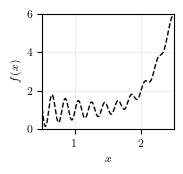

In [159]:

f = GandL_1D()

xmin, xmax = 0.5, 2.5
ymin, ymax = 0, 6
xx = np.linspace(xmin, xmax, 200).reshape(-1, 1) 

np.random.seed(2)
N = 60  
sigma  = 0.15
X = np.random.uniform(f.xmin, f.xmax, (N, f.xdim))
delta = np.random.normal(0, sigma, (N, 1))
Y = f(X) + delta
data = (tf.convert_to_tensor(X, "float64"), tf.convert_to_tensor(Y, "float64"))

fig = plt.figure()
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
#fig.axes[0].yaxis.set_label_coords(-0.18, .5)
#fig.axes[0].xaxis.set_label_coords(0.5, -0.18)
#plt.xticks([-10, 0, 10])
#plt.yticks([-10, 0, 10])
plt.xlim(xmin, xmax)
plt.ylim(ymin,ymax)
#plt.title("".join(['$\Vert f \Vert_\mathcal{H} = \;$', str(round(s.norm(),2))]))
plt.plot(xx, f(xx), "k--")

#plt.plot(X, Y, "o")
#plt.text(-1.5, 1.8,"$f^\star(x)$")#, fontsize=7)

filename = 'chap3_ex_gp_A'
plt.savefig("".join([plot_params.path_to_img_folder, filename, ".pdf"]), bbox_inches='tight', pad_inches = 0.)

GPR trained:
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.alpha        │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │     100 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─

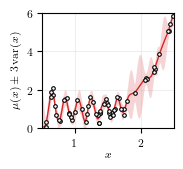

In [195]:
#kernel = gpflow.kernels.SquaredExponential(lengthscales=1)
kernel = gpflow.kernels.RationalQuadratic(lengthscales=1, alpha=100)

my_gp  = gpflow.models.GPR(data, kernel=kernel) 
opt = gpflow.optimizers.Scipy()
print('GPR trained:'), print_summary(my_gp)
opt.minimize(my_gp.training_loss, my_gp.trainable_variables, tol=1e-11, options=dict(maxiter=5000), method='bfgs')#method='SLSQP')#method='l-bfgs-b')
print('GPR trained:'), print_summary(my_gp)
print('GPR likelihood:'), print(my_gp.log_marginal_likelihood())

mean, var = my_gp.predict_f(xx)

# Plotting the results (two standard deviations = 95% confidence)
fig = plt.figure()
plt.xlabel('$x$')
plt.ylabel('$\mu(x) \,\pm$ 3$\,$var$(x)$')
fig.axes[0].xaxis.set_label_coords(0.5, -0.18)
plt.plot(xx, mean, color=plot_params.colors["red"])
plt.fill_between(xx[:,0],
                 mean[:,0] - 3 * np.sqrt(var[:,0]),
                 mean[:,0] + 3 * np.sqrt(var[:,0]),
                 color=plot_params.colors["red"],
                 alpha=0.2, lw=0)

plt.plot(X, Y, "o", ms=2.6)
plt.xlim(xmin, xmax)
plt.ylim(ymin,ymax)

filename = 'chap3_ex_gp_B'
plt.savefig("".join([plot_params.path_to_img_folder, filename, ".pdf"]), bbox_inches='tight', pad_inches = 0.)


GPR trained:
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │        value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │     46.6257  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │      1.20071 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.kernel.alpha        │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 519629       │
├─────────────────────────┼───────────┼────

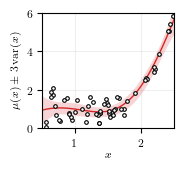

In [194]:
#kernel = gpflow.kernels.SquaredExponential(lengthscales=0.01)
kernel = gpflow.kernels.RationalQuadratic(lengthscales=0.01, alpha=100)

my_gp  = gpflow.models.GPR(data, kernel=kernel) 
opt = gpflow.optimizers.Scipy()
opt.minimize(my_gp.training_loss, my_gp.trainable_variables, tol=1e-11, options=dict(maxiter=5000), method='bfgs')#method='SLSQP')#method='l-bfgs-b')
print('GPR trained:'), print_summary(my_gp)
print('GPR likelihood:'), print(my_gp.log_marginal_likelihood())

mean, var = my_gp.predict_f(xx)

# Plotting the results (two standard deviations = 95% confidence)
fig = plt.figure()
plt.xlabel('$x$')
plt.ylabel('$\mu(x) \,\pm$ 3$\,$var$(x)$')
fig.axes[0].xaxis.set_label_coords(0.5, -0.18)
plt.plot(xx, mean, color=plot_params.colors["red"])
plt.fill_between(xx[:,0],
                 mean[:,0] - 3 * np.sqrt(var[:,0]),
                 mean[:,0] + 3 * np.sqrt(var[:,0]),
                 color=plot_params.colors["red"],
                 alpha=0.2, lw=0)
plt.plot(X, Y, "o", ms=2.6)
plt.xlim(xmin, xmax)
plt.ylim(ymin,ymax)

filename = 'chap3_ex_gp_C'
plt.savefig("".join([plot_params.path_to_img_folder, filename, ".pdf"]), bbox_inches='tight', pad_inches = 0.)

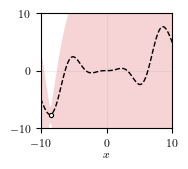

In [235]:
np.random.seed(1) 
k = RBF(length_scale=2)

xmin, xmax = -10., 10
xx = np.linspace(xmin, xmax, 100).reshape(-1, 1) 

n_centers = 15
centers = np.linspace(xmin*0.6, xmax*0.6, n_centers).reshape(-1, 1)
values = 0.1*(np.square(centers) * np.sin(centers))
s = Interpolant(k, centers, values, jitter=1e-10)
gamma = s.norm()

#X = np.array([-8, -5, -2, 0, 2, 5, 8]).reshape(-1,1)
X = np.array([-8.5]).reshape(-1,1)
fX = s(X)

delta_bar = 0.8
delta = np.random.uniform(-delta_bar, delta_bar, fX.shape)
Y = fX + delta

bounds = Optimal_Bounds(X, Y, k, gamma, delta_bar)
ub = bounds(xx, "upper")
lb = bounds(xx, "lower")

fig = plt.figure()
plt.xlabel('$x$')
fig.axes[0].xaxis.set_label_coords(0.5, -0.18)
plt.xticks([-10, 0, 10])
plt.yticks([-10, 0, 10])
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.plot(xx, s(xx), "k--")
plt.fill_between(xx.reshape(-1,), ub.reshape(-1,), lb.reshape(-1,), facecolor=plot_params.colors["red"], alpha=0.2)
plt.plot(X, Y, "o")

filename = 'chap2_ex3_opt_bounds_A'
plt.savefig("".join([plot_params.path_to_img_folder, filename, ".pdf"]), bbox_inches='tight', pad_inches = 0.)

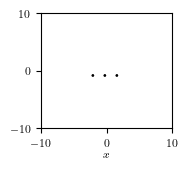

In [243]:

fig = plt.figure()
plt.xlabel('$x$')
plt.xticks([-10, 0, 10])
plt.yticks([-10, 0, 10])
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.grid(0)
fig.axes[0].xaxis.set_label_coords(0.5, -0.18)
plt.text(-2.3, -1.2,"$\cdots$", fontsize=20)

filename = 'chap2_ex3_dots'
plt.savefig("".join([plot_params.path_to_img_folder, filename, ".pdf"]), bbox_inches='tight', pad_inches = 0.)
